# Local Embedding for SDM's // Metric data

### Locally Linear Embedding (LLE) algorithm (not this one implemented)
### https://redwood.berkeley.edu/wp-content/uploads/2018/06/chen2018sparse.pdf
### [48] Sam T Roweis and Lawrence K Saul. Nonlinear dimensionality reduction by locally linearembedding.science, 290(5500):2323–2326, 2000.

In [9]:

using JSON
using Glob
using Dates
using Plots
using ProgressMeter
using DataFrames
using CSV
using StatsBase
using SparseArrays


include("../src/manifoldLearning.jl")
include("../src/encoding.jl")


encodeData2SparseMat (generic function with 1 method)

### Generate Data

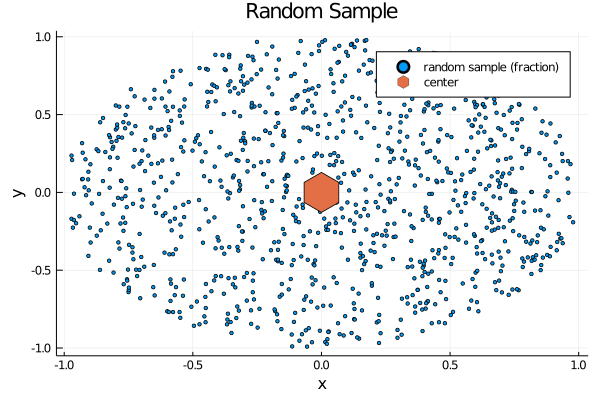

In [10]:

struct Data2D
    
    x::Float64
    y::Float64
    
end

dist2D(pt1::Data2D, pt2::Data2D) = (pt1.x-pt2.x)^2 + (pt1.y-pt2.y)^2


nData = 5000000
data = [Data2D(0., 0.)]
while length(data) < nData
    x, y = 2*rand()-1, 2*rand()-1
    if x^2 + y^2 < 1.
        push!(data, Data2D(x, y))
    end
end


scatter(map(d -> d.x, data[1:1000]),
        map(d -> d.y, data[1:1000]),
        label="random sample (fraction)", marker=(:circle,2,1.))


scatter!([data[1].x], [data[1].y],
         label="center", marker=(:hexagon, 20, 1.), 
         xlabel = "x", ylabel="y", title="Random Sample")


### Data to Encode

In [11]:

data2Encode = Data2D[]

while length(data2Encode) < 1000
    
    x, y = 2*rand()-1, 2*rand()-1
    
    if x^2 + y^2 < 1.
        push!(data2Encode, Data2D(x, y))
    end
    
end


In [12]:

localembedder = LocallyLinearEmbedding(10000,4,data);


### encode Indices // Metric Model

In [13]:

encoderModel = Dict(:N => 10000, :W => 10)

encoder = dicData -> encodeData2Idces(dicData, localembedder, 10, dist2D)

encoder(data2Encode[1]);


### Encode data into HD vector and matrices

In [14]:

hdVec = encodeData2SparseVec(data2Encode[1], encoder, encoderModel)

hdMat = encodeData2SparseMat(data2Encode[1:100], encoder, encoderModel);


Progress: 100%|█████████████████████████████████████████| Time: 0:03:36


### Encode data // Adjacency Matrices

In [17]:

nData = 5000
adjacencyMatrix = zeros(nData, nData)

for i=1:nData
    for j=1:nData
        adjacencyMatrix[i,j] = dist2D(data[i], data[j]) < 0.2
    end
end


adjacencyMatrix = zeros(nData, nData)

I, J, K = [], [], []
@showprogress for i=1:nData
    for j=1:nData
        if dist2D(data[i], data[j]) < 0.2
            
            adjacencyMatrix[i,j] = 1
            push!(I, i); push!(J, j); push!(K, 1)
            
        end
    end
end

sparseAdjMatrix = sparse(I, J, K, nData, nData);



Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


In [18]:

data2Encode = Data2D[]
nData2Encode = 1000

while length(data2Encode) < nData2Encode
    
    x, y = 2*rand()-1, 2*rand()-1
    
    if x^2 + y^2 < 1.
        push!(data2Encode, Data2D(x, y))
    end
    
end


### Encode data (Adjacency Matrix)

In [19]:

encoderModel = Dict(:N => 10000, :W => 10)

localembedder = LocallyLinearEmbedding(encoderModel[:N],encoderModel[:W],adjacencyMatrix);


In [20]:
idx = 1
nNeighb = 2
encodeData2Idces(idx, localembedder, nNeighb)

20-element Array{Int64,1}:
 2758
 6664
 4394
 9232
 9300
 1526
 2184
 5667
 5039
 3494
 5041
 8947
 6677
 1515
 1583
 3809
 4467
 7950
 7322
 5777

In [22]:
encoder=idx->encodeData2Idces(idx, localembedder, 10)
@time hdMat = encodeData2SparseMat(collect(1:nData2Encode), encoder, encoderModel);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 10.007337 seconds (173.86 M allocations: 2.681 GiB, 36.09% gc time)


### Encode data (Sparse Matrix)

In [23]:

encoderModel = Dict(:N => 10000, :W => 10)

localembedder = LocallyLinearEmbedding(encoderModel[:N],encoderModel[:W],sparseAdjMatrix);


In [24]:
encoder=idx->encodeData2Idces(idx, localembedder, 10)

#57 (generic function with 1 method)

In [25]:
@time hdMAT = encodeData2SparseMat(collect(1:nData2Encode), encoder, encoderModel);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.576783 seconds (418.26 k allocations: 58.190 MiB, 3.04% gc time)
